# Training a Diffusion Model on 2D Points

Diffusion models have revolutionized generative AI, but they can be complex to understand. In this tutorial, we'll build intuition by training a diffusion model on a simple 2D spiral dataset. This allows us to visualize the entire process and understand key concepts without the complexity of image generation.

In this notebook, you'll learn how to train a diffusion model to generate spirals of 2-D points.

## What We'll Cover

- Forward diffusion: How to gradually add noise to data
- Reverse diffusion: How to learn to denoise data
- Three different model architectures and their tradeoffs
- Visualization of the diffusion process

## Why 2D Points?

Working with 2D points offers several advantages:

- Fast training on CPU
- Easy visualization of the entire process
- Clear understanding of how diffusion models work

We'll explore the different components of diffusion models and their functions, as well as compare the quality of generated results using different model architectures. 

In [1]:
from dataclasses import dataclass
import math
from typing import Dict, Tuple

from matplotlib import pyplot as plt
from sklearn.datasets import make_swiss_roll
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# The Data

First, let's take a look at the data we'll be working with.

We'll work with a 2D spiral dataset. While simple, this dataset has interesting properties:

- Non-linear structure
- Clear visual pattern.

This makes it a great dataset for understanding how diffusion models learn to generate structured data from noise.


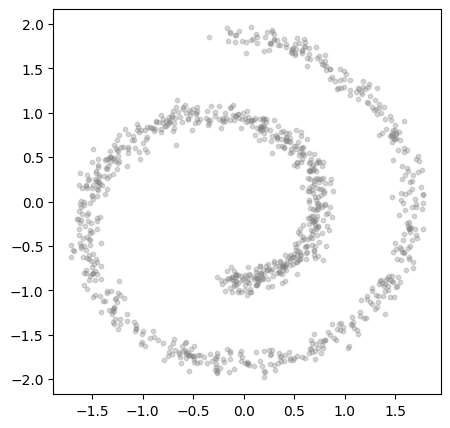

In [2]:
x, _ = make_swiss_roll(n_samples=1000, noise=0.5)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()
plt.figure(figsize=(5, 5))
_ = plt.scatter(x[:, 0], x[:, 1], s=10, alpha=0.3, color="Gray")

### Dataloaders

Before training the model, we need to define some hyperparameters and create our train and validation dataloaders.

The `TrainingConfig` class contains a couple of parameters for the training process. `batch_size`, `learning_rate`, `weight_decay` are common parameters for the optimizer and dataloader. Specific to diffusion, `num_denoising_steps` is the number of timesteps in the diffusion process.

In [3]:
device = torch.device("cpu")

@dataclass
class TrainingConfig:
    batch_size: int = 256  # batch size
    learning_rate: float = 5e-4  # initial learning rate
    weight_decay: float = 1e-6  # weight decay
    num_denoising_steps: int = 1000  # number of timesteps

    n_training_examples: int = int(1e+5)  # number of training examples

Following [pytorch's `Dataset` convention](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), we define a `SimpleDataset` class to wrap the `numpy` array data and expose the `__len__` and `__getitem__` methods, to allow us to query the dataset length and get any training example by index.

We took 100,000 examples from the swiss roll dataset and randomly split them into 80% training and 20% validation.


In [4]:

def load_data(config: TrainingConfig) -> Tuple[DataLoader, DataLoader]:
    """
    Load the data and return the train and validation dataloaders.

    Args:
      config: TrainingConfig object.
    Returns:
      train_dataloader: DataLoader for the training data.
      val_dataloader: DataLoader for the validation data.
    """
    n = config.n_training_examples
    x, _ = make_swiss_roll(n_samples=n, noise=0)
    x = x[:, [0, 2]]
    scaling = 2
    x = (x - x.mean()) / x.std() * scaling
    x_train = x[:int(n * 0.8), :]
    x_val = x[int(n * 0.8):, :]

    class SimpleDataset:
      def __init__(self, data):
        self.data = data

      def __len__(self):
        return len(self.data)

      def __getitem__(self, i):
        return self.data[i]

    train_dataset = SimpleDataset(x_train)
    val_dataset = SimpleDataset(x_val)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

    return train_dataloader, val_dataloader


config = TrainingConfig()
train_dataloader, val_dataloader = load_data(config)
first_batch = next(iter(train_dataloader))
print("batch shape:", first_batch.shape)

batch shape: torch.Size([256, 2])


Note that the batch shape is (256, 2), which means we have 256 samples in the batch, each with 2 features (x and y coordinates).

When we work on images, the batch shape would be (batch_size, channels=3, height, width).

Now we have the dataloaders ready, let's move on to teaching the model. The forward diffusion sets up the learning path for the model.

## Forward Diffusion: the Teaching

Diffusion algorithms have two main processes: Forward Diffusion and Reverse Denoising. Let's start with forward diffusion.

We gradually add noise to our spiral data according to a carefully designed schedule. This creates a sequence:

- Clean data → Slightly noisy → More noisy → Pure noise

Forward diffusion can be considered as "data augmentation" in the training step. It adds noise to the data to challenge the model to be able to tell apart signal from noise. Diffusion is a particular way of adding noise, with a carefully designed noise schedule.

The forward diffusion defines a sequence of data points (each $x_t$ is a 2 dimensional vector):

$$x_0, x_1, x_2, ..., x_T$$

where T is the number of diffusion steps (e.g. 1000).

Similar to an algebraic sequence with a common difference, the diffusion sequence has a "common noise" $\mathbf\epsilon$ that is the same for all steps in a sequence. The recursive formula of the diffusion sequence is:

$$
x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{\beta_t} \mathbf\epsilon
$$

where $\beta_t = 1 - \alpha_t$ is the variance of the noise at time $t$. This relationship is primarily a design choice that simplifies the mathematics and makes the derivations more elegant and manageable.

One can then derive the explicit formula for $x_t$ expressed in terms of $x_0$ and $\mathbf\epsilon$:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \mathbf\epsilon
$$

where $\bar\alpha_t = \prod_{i=1}^t \alpha_i$ is the cumulative product of the variance of the noise at time $t$.

The forward diffusion process is thus defined by this noise schedule: $\beta_1, \beta_2, ..., \beta_T$.

In [5]:
def forward_diffusion(x_0, t, noise_schedule, noise=None):
    """
    Applies forward diffusion to input data.
    
    Args:
        x_0: Clean input data
        t: Timestep
        noise_schedule: Dictionary containing pre-computed noise parameters
        noise: Optional pre-generated noise
        
    Returns:
        x_t: Noised version of input
        noise: The noise that was added
    """
    t_shape = (-1,) + (1,) * (x_0.ndim - 1)
    _ts = t.view(*t_shape)
    if noise is None:
        noise = torch.randn_like(x_0)
    assert _ts.max() < len(noise_schedule["alphas_cumprod"]), f"t={_ts.max()} is larger than the length of noise_schedule: {len(noise_schedule['alphas_cumprod'])}"
    alpha_prod_t = noise_schedule["alphas_cumprod"][_ts]
    x_t = (alpha_prod_t ** 0.5) * x_0 + ((1 - alpha_prod_t) ** 0.5) * noise
    return x_t, noise

### Noise Schedule

Here we create our noise shedule for the diffusion process, which controls how noise is added to the data across timesteps during forward difffusion. The schedule is parametized by $\beta_{min}$ and $\beta_{max}$ which define the range of noise intensity values.

The range of $\beta_t$ is empirically chosen to be between 1e-4 and 0.02. We can plot the noise schedule curves to visualize the blending ratio between the clean data and the noise, and how it changes over "time" through the diffusion process.

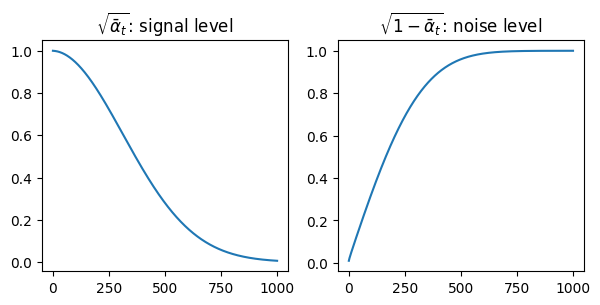

In [6]:
beta_min, beta_max = 1e-4, 0.02
# beta_min, beta_max = 1e-4, 1
# beta_min, beta_max = 0, 0.02

def create_noise_schedule(n_T: int, device: torch.device) -> Dict[str, torch.Tensor]:
    betas = torch.linspace(beta_min, beta_max, n_T).to(device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0).to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1).to(device), alphas_cumprod[:-1].to(device)])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "betas": betas,
        "alphas_cumprod": alphas_cumprod,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance,
    }


noise_schedule = create_noise_schedule(config.num_denoising_steps, device)

# plot the schedule
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1); plt.plot(range(1000), noise_schedule["sqrt_alphas_cumprod"].cpu().numpy())
plt.title(r"$\sqrt{\bar\alpha_t}$: signal level")

plt.subplot(1, 2, 2); plt.plot(range(1000), noise_schedule["sqrt_one_minus_alphas_cumprod"].cpu().numpy())
_ = plt.title(r"$\sqrt{1-\bar\alpha_t}$: noise level")

Let's take a look at the process in action.

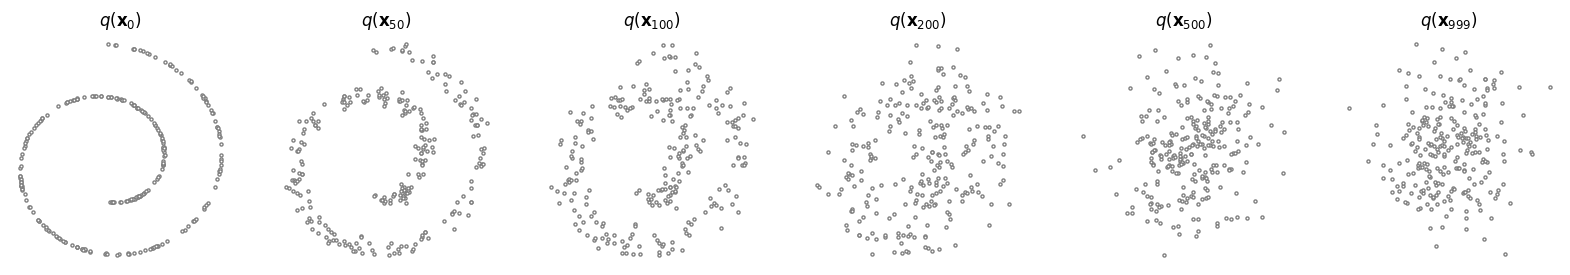

In [7]:
x_0 = next(iter(val_dataloader))
x_0 = x_0.to(device)
x_t_list = []
common_noise = torch.randn_like(x_0)

fig, axs = plt.subplots(1, 6, figsize=(20, 3))
for i, t in enumerate([0, 50, 100, 200, 500, 999]):
    t_ = torch.full((x_0.shape[0],), t, device=device)
    x_t = forward_diffusion(x_0, t_, noise_schedule, noise=common_noise)[0]
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white', edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{'+str(t)+'})$')

As the noise increases, the orderly spiral quickly fades away as it becomes a disordered pile of points.

### Visualize forward diffusion trajectories

Let's plot the trajectories of the forward diffusion process. For each data point $\mathbf{x}_0$, we plot the sequence:

$$ \mathbf{x}_0, \mathbf{x}_{10}, \mathbf{x}_{20}, \ldots, \mathbf{x}_{990} $$

Would they look like straight lines or curves?

#### Tools for Visualizing Trajectories

Here are some utility functions to plot the trajectories of the diffusion process.

In [8]:
from typing import Tuple


class TrajectorySet:
    def __init__(self, embeddings):
        """
        Managing a set of trajectories, each of which is a sequence of embeddings.

        Parameters
        ----------
        embeddings: (n_timesteps, n_samples, *embedding_dims). This assumes
            the first dimension is time. And it is ordered from t=0 to t=n_timesteps-1.
            With t=0 representing the clean data and t=n_timesteps-1 representing the noise.

        """
        self.embeddings = embeddings
        self.embeddings_2d = None
    
    def run_tsne(self, n_components: int = 2, seed: int = 0, **kwargs):
        """Run t-SNE on the embeddings.
        """
        print(f"Running t-SNE on {self.embeddings.shape} embeddings...")
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=n_components, random_state=seed, **kwargs)
        flattened_embeddings = self.embeddings.reshape(-1, self.embeddings.shape[-1])
        flattened_embeddings_2d = tsne.fit_transform(flattened_embeddings)
        self.embeddings_2d = flattened_embeddings_2d.reshape(self.embeddings.shape[0], self.embeddings.shape[1], -1)
        print(f"t-SNE done. Shape of 2D embeddings: {self.embeddings_2d.shape}")
        return self.embeddings_2d
    
    def plot_trajectories(
            self,
            n: int = 10,
            show_figure: bool = False,
            noise_color: Tuple[float, float, float] = (0, 0, 1),  # blue
            data_color: Tuple[float, float, float] = (1, 0, 0),  # red
            figsize: tuple = (6, 6),
            xlim: Tuple[float, float] = None,
            ylim: Tuple[float, float] = None,
            with_ticks: bool = False,
            with_lines: bool = True,
            title: str = None,
            tsne_seed: int = 0,
            **kwargs):
        """Plot trajectories of some selected samples.

        This assumes the first dimension is time. And it is ordered from t=0 to t=n_timesteps-1.
        With t=0 representing the clean data and t=n_timesteps-1 representing the noise.

        Parameters
        ----------
        n: int
            number of samples to plot
        figsize: tuple
            figure size
        kwargs:
            other keyword arguments for matplotlib.pyplot.scatter
        """
        import numpy as np
        import matplotlib.pyplot as plt

        colors = []
        for t in range(self.embeddings.shape[0]):
            # interpolate between noise_color and data_color
            factor = t / (self.embeddings.shape[0] - 1)
            colors.append(np.array(noise_color) * factor + np.array(data_color) * (1 - factor))
        colors = np.array(colors)
        
        if self.embeddings_2d is None:
            if self.embeddings.shape[2] == 2:
                self.embeddings_2d = self.embeddings
            else:
                self.embeddings_2d = self.run_tsne(seed=tsne_seed)

        traj = self.embeddings_2d[:, :n, :]
        g = plt.figure(figsize=figsize)
        plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="red")  # real
        plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")  # noise
        plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.5, alpha=0.7, c=colors.repeat(n, axis=0))  # "olive"
        if with_lines:  
            plt.plot(traj[:, :n, 0], traj[:, :n, 1], c="olive", alpha=0.3)
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        if with_lines:
            plt.legend(["Data", "Noise", "Intermediate Samples (color coded)", "Trajectory"], loc="upper right")
        else:
            plt.legend(["Data", "Noise", "Intermediate Samples (color coded)"], loc="upper right")
        if not with_ticks:
            plt.xticks([])
            plt.yticks([])
        elif xlim is not None and ylim is not None:
            plt.xticks(xlim)
            plt.yticks(ylim)
        if title is not None:
            plt.title(title)
        if show_figure:
            plt.show()
        
        plt.tight_layout()
        # save to bytes (png)
        import io

        bytes_io = io.BytesIO()
        g.savefig(bytes_io, format="png")
        return bytes_io.getvalue()
        
        # # return the figure
        # return plt.gcf()


#### Plotting the forward diffusion trajectories

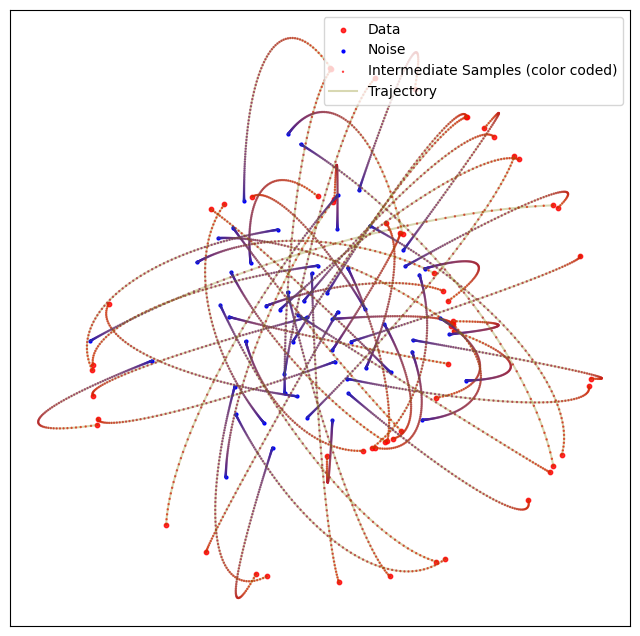

<Figure size 640x480 with 0 Axes>

In [9]:
# Generate forward diffusion trajectories (would they look like straight lines or curves?)

x_clean = next(iter(val_dataloader))
x_clean = x_clean.to(device)

# Run forward diffusion
x_t_list = []
torch.manual_seed(0)
common_noise = torch.randn_like(x_clean)

for t in range(0, 1000, 10):
    t_ = torch.full((x_clean.shape[0],), t, device=device)
    x_t = forward_diffusion(x_clean, t_, noise_schedule, noise=common_noise)[0]
    x_t_list.append(x_t)

traj = torch.stack(x_t_list).cpu().numpy()
traj_set = TrajectorySet(traj)
_ = traj_set.plot_trajectories(n=60, show_figure=True, figsize=(8, 8))

The dotted lines are the trajectories of the forward diffusion. Good data points on the spiral pattern (red) are gradually transformed into noise (blue), which is a Gaussian distribution.

### Forward Diffusion is a Form of Data Augmentation

We can consider this as a data augmentation process. For each clean data point, a noisy data point is created by adding noise to it. 

One could write a new dataset class to represent this data augmentation process:

```python
class DiffusionAugmentedDataset:
    def __getitem__(self, index):
        x_0 = self.data[index]
        t = torch.randint(0, self.num_timesteps, (1,))
        x_t, noise = forward_diffusion(x_0, t, self.noise_schedule)
        inputs = (t, x_t)
        targets = noise
        return inputs, targets
```

By doing so, we cast the generation problem as a supervised learning problem.

In this notebook, to keep the code simple, we implement the data augmentation inside the training step on mini-batches, as commonly done in practice.




# The Learning

## Denoising: Reverse diffusion

Now that we understand how forward diffusion works, we need a model that can learn to reverse this process, and get back to the clean data.

We call such a model a denoising model. It predicts the noise at each time step $t$ and the current state of the data $x_t$. It is paramterized as a neural network:

$$
\mathbf\epsilon_{\theta}(t, \mathbf{x_t})
$$

where $\theta$ is the parameters of the denoising model. $t$ is a scalar value that represents the current time step or progress in the diffusion process. $t$ is also referred to as the noise level, with 0 indicating the clean data and $T$ (e.g. $T=1000$) indicating the fully noisy data.

::: {.callout-note}
Side note: There are other ways to parameterize the problem. For example, some train a model to predict the previous state $x_{t-1}$ directly. In this tutorial, we focus on the standard noise prediction formulation.
:::

When generating data with the denoising model, we use this model to iteratively remove noise from the data point and move it back towards $x_0$. This is the reverse diffusion process.

We'll define the individual denoising step for this process later.


For now, a key challenge is designing a model architecture that can effectively understand both the noisy input $x_t$ and the current time step $t$.




## Network Architecture of the Denoising Model

The network architecture of the denoising model can be quite flexible, as long as it can take the time step $t$ and the noisy data $x_t$ as input, and output a tensor of the same shape as $x_t$. We'll implement three different model architectures to incorporate time information with the data:

**Model 1: Basic**
- Simplest approach: direct concatenation of time with noisy data.

**Model 2: Sinusoidal Time Embedding**
- Inspired by transformer positional encodings.
- Better representation of the time step.

**Model 3: Time-Modulated Linear Layers**
- The output of each linear transformation is modulated by a learned time embedding through element-wise multiplication, allowing the network to adapt its representations based on the timestep.
- Time information influences every layer.

Below is a table summarizing the design choices:

| Architecture | Timestep Handling | Pros | Cons |
|-------|---------------|------|------|
| Model 1: Basic | Direct concatenation | Simple, lightweight | Limited temporal understanding |
| Model 2: Sinusoidal | Transformer-style embeddings | Better periodic patterns | More parameters |
| Model 3: Modulation | Time influences all layers | Most expressive | Most complex |


### Model 1: Simple Concatination 

Our first model is a simple three layer MLP. Note that in the `foward` method, we concatinate the time to the noisy data before each foward pass.

In [10]:
class Model1(nn.Module):
    def __init__(self, hidden_features: list[int]):
        super().__init__()
        
        layers = []
        input_dim = 3  # The input dimension (t and x combined)
        
        for hidden_dim in hidden_features:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(input_dim, 2))
        layers.append(nn.Tanh())
        
        self.net = nn.Sequential(*layers)

    def forward(self, t, x):
        t = t / 1000.
        t = t.reshape(-1, 1)
        return self.net(torch.cat([t, x], 1))

# Example usage
hidden_dimensions = [512, 512]  # Example list of hidden dimensions
device = "cpu"
model1 = Model1(hidden_dimensions).to(device)

print(f"Model parameters: {sum(p.numel() for p in model1.parameters())}")


Model parameters: 265730


### Model 2: Sinusoidal Time Embedding Concatination

In this model, we utilize a 3-layer MLP. Instead of concatenating the raw time embedding directly to the data embedding, we first transform the time embedding into a sinusoidal embedding and then concatenate it with the data embedding.

**Background**

This model builds upon the idea of incorporating temporal information into the embedding space, inspired by the effectiveness of sinusoidal embeddings in positional encoding for transformers. The sinusoidal representation allows the model to capture periodicity and smooth transitions in the time domain, potentially improving its ability to generalize across different temporal contexts.

In [11]:
class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: list[int],
    ):
        layers = []

        for a, b in zip(
            (in_features, *hidden_features),
            (*hidden_features, out_features),
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])


class Model2(nn.Module):
    def __init__(self, features: int, freqs: int = 16, **kwargs):
        super().__init__()

        self.net = MLP(2 * freqs + features, features, **kwargs)

        self.register_buffer('freqs', torch.arange(1, freqs + 1) * torch.pi)

    def forward(self, t, x):
        t = t / 1000.
        t = self.freqs * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)

        return self.net(torch.cat((t, x), dim=-1))


model2 = Model2(features=2, hidden_features=[512, 512]).to(device)
print(f"model params: {sum(p.numel() for p in model2.parameters())}")

model params: 281602


### Model 3: Time-Modulated Linear Layers

Model 3 ([reference](https://github.com/KAIST-Visual-AI-Group/Diffusion-Assignment1-DDPM)) introduces a time-conditioned architecture where time is incorporated directly into the network through TimeLinear layers. Instead of directly concatenating time embeddings with the data embeddings, the output of each linear transformation is modulated by a learned time embedding through element-wise multiplication, allowing the network to adapt its representations based on the timestep.

In [12]:
class TimeEmbedding(nn.Module):
    """
    Time embedding module that embeds the time step into a hidden representation.
    Args:
        hidden_size: the size of the hidden representation.
        frequency_embedding_size: the size of the frequency embedding
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        """Forward pass of the module."""

        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class TimeLinear(nn.Module):
    """
    Time linear layer that applies a linear transformation with time-dependent weights.
    """

    def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
        """
        Args:
            dim_in: the number of input features.
            dim_out: the number of output features.
            num_timesteps: the number of timesteps.
        """
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.num_timesteps = num_timesteps

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)
        return alpha * x


class Model3(nn.Module):
    def __init__(
        self, hidden_features: list[int], num_timesteps: int, dim_in:int = 2, dim_out:int = 2,
    ):
        super().__init__()
        """
        Build a noise estimating network.

        Args:
            hidden_features: dimensions of hidden features
            num_timesteps: number of timesteps
            dim_in: dimension of input
            dim_out: dimension of output
        """

        layers = []
        dims = [dim_in] + hidden_features

        # Build MLP layers with time-dependent linear layers
        for i in range(len(dims)-1):
            layers.append(TimeLinear(dims[i], dims[i+1], num_timesteps))
            layers.append(nn.ReLU())

        # Final layer to output noise prediction
        layers.append(TimeLinear(dims[-1], dim_out, num_timesteps))

        self.net = nn.Sequential(*layers)
        self.num_timesteps = num_timesteps


    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
            x: the noisy data after t period diffusion
            t: the time that the forward diffusion has been running
        """
        for layer in self.net:
            if isinstance(layer, TimeLinear):
                x = layer(x, t)
            else:
                x = layer(x)
        ######################
        return x


model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[512, 512],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")

model params: 1054218


# Generation

### The sampling algorithm: reversing the diffusion process

The sampling algorithm is the reverse of the forward diffusion process. It starts from $x_T$, a pure noise image, and iteratively denoise until reaching $x_0$.

The formula for one "denoising" step is:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1 - \bar\alpha_t}} \mathbf\epsilon_{\theta}(\mathbf{x_t}, t)) + \sqrt{\tilde\beta_t} \mathbf z_t \tag{1}
$$

where $z_t ~ \mathcal{N}(0, 1)$ is Gaussian noise (independent from $\mathbf\epsilon$) that is sampled at each denoising step, and $\tilde\beta_t = \frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t$ is the variance of the noise at time $t$.

Let's implement the denoising step.

In [13]:
def denoising_step(denoising_model, x_t, t, noise_schedule, thresholding=False):
    """
    This is the backward diffusion step, with the effect of denoising.
    """
    if isinstance(t, int):
        t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device)
    else:
        t_tensor = t
    with torch.no_grad():
        model_output = denoising_model(t=t_tensor, x=x_t)
    if hasattr(model_output, "sample"):
        model_output = model_output.sample

    # Extract relevant values from noise_schedule
    alpha_prod_t = noise_schedule["alphas_cumprod"][t_tensor]
    # deal with t=0 case where t can be a tensor
    alpha_prod_t_prev = torch.where(t_tensor > 0,
                                    noise_schedule["alphas_cumprod"][t_tensor - 1],
                                    torch.ones_like(t_tensor, device=x_t.device))

    # Reshape alpha_prod_t_prev for proper broadcasting
    view_shape = (-1,) + (1,) * (x_t.ndim - 1)
    alpha_prod_t = alpha_prod_t.view(*view_shape)
    alpha_prod_t_prev = alpha_prod_t_prev.view(*view_shape)

    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # Compute the previous sample mean
    pred_original_sample = (x_t - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

    # Compute the coefficients for pred_original_sample and current sample
    pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** 0.5 * beta_prod_t_prev / beta_prod_t

    # Compute the previous sample
    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * x_t

    # Add noise
    variance = torch.zeros_like(x_t)
    variance_noise = torch.randn_like(x_t)

    # Handle t=0 case where t can be a tensor
    non_zero_mask = (t_tensor != 0).float().view(view_shape)
    variance = non_zero_mask * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t)
    variance = torch.clamp(variance, min=1e-20)

    pred_prev_sample = pred_prev_sample + (variance ** 0.5) * variance_noise

    return pred_prev_sample


def generate_samples_by_denoising(denoising_model, x_T, noise_schedule, n_T, device, thresholding=False, seed=0, return_full_trajectory=False, silent=False):
    """
    This is the generation process.
    """
    torch.manual_seed(seed)

    x_t = x_T.to(device)
    pbar = tqdm(range(n_T - 1, -1, -1), disable=silent)
    if return_full_trajectory:
        x_t_list = []
    for t in pbar:
        x_t = denoising_step(denoising_model, x_t, t, noise_schedule, thresholding)
        if not silent:
            pbar.set_postfix({"std": x_t.std().item()})
        if return_full_trajectory:
            x_t_list.append(x_t)

    if return_full_trajectory:
        return torch.stack(x_t_list).cpu()
    else:
        return x_t.cpu()


### Visualize denoising trajectories of an untrained model

Let's create a model from scratch. Before the model is trained, what would the denoising trajectories look like?

model params: 281354


  0%|          | 0/1000 [00:00<?, ?it/s]

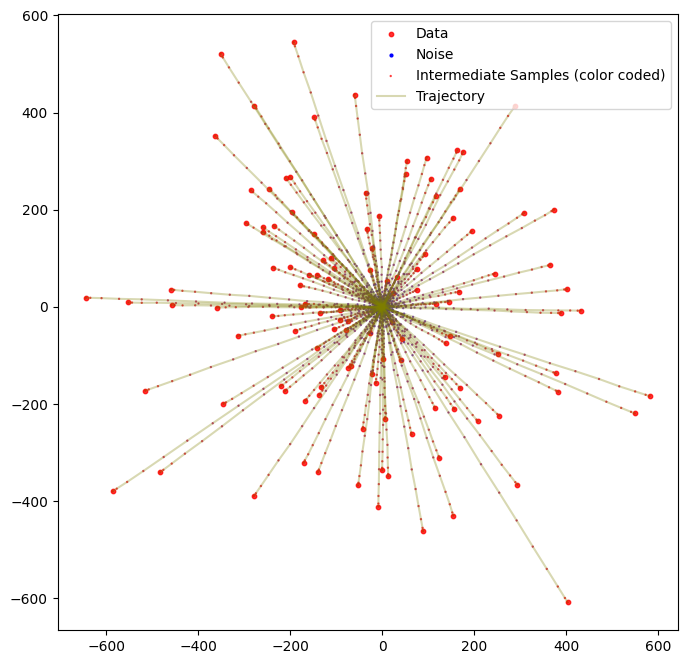

<Figure size 640x480 with 0 Axes>

In [14]:
# Define a model and optimizer
model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[128, 128, 256],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")

# visualize denoising trajectories
def visualize_denoising_trajectories(model, n=16):
    x_T = torch.randn(n, 2)
    traj = generate_samples_by_denoising(model, x_T, noise_schedule, n_T=1000, device=device, return_full_trajectory=True).cpu().detach().numpy()
    traj = traj[::-50]
    traj_set = TrajectorySet(traj)
    _ = traj_set.plot_trajectories(n=n, show_figure=True, figsize=(8, 8), with_ticks=True)

visualize_denoising_trajectories(model3, n=120)


The paths look like straight lines. The blue dots are the starting points (not even visible because they are crowded around the origin), and the red dots are the generated data.

The generated data points traveled quite far from the origin. There is no sign of the spiral.

Apparently the model needs to learn. So let's implement the training algorithm.

## Training loop

We teach the model to predict the "common noise" $\mathbf\epsilon$ that produced the diffusion sequence. The model bases its prediction on $x_t$ at any time (or noise level) $t$. No matter where it is, the model needs to help the data point get back to $x_0$.

For each clean training example $x_0$, we sample a random time $t$ and compute the forward diffusion of $x_0$ to get the noisy data $x_t$. We then compute the predicted noise $\mathbf\epsilon$ using the model.

A simple MSE loss is used to compare the predicted noise with the true noise. This feedback is propagated back to the model to update its parameters.

The core training step can be implemented in under 10 lines of code.

We repeat it a number of times in the training loop.

In [15]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, steps: int=100, silent: bool=False) -> float:
  criterion = MSELoss()
  model.train()
  if not silent:
    print("Training on device:", device)
  max_train_steps = steps

  loss = None
  step = 0
  while step < max_train_steps:
    progress_bar = tqdm(train_dataloader, disable=silent)
    for x_0 in progress_bar:
      x_0 = x_0.float().to(device)  # x_0 is the clean data

      #######################################
      # Start of the core training step
      #######################################
      optimizer.zero_grad()
      true_noise = common_noise = torch.randn(x_0.shape).to(device)
      t = torch.randint(0, config.num_denoising_steps, (x_0.shape[0],), device=device).long()
      x_t, _ = forward_diffusion(x_0, t, noise_schedule, noise=common_noise)

      predicted_noise = model(t=t, x=x_t)

      loss = criterion(predicted_noise, true_noise)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # try commenting it out
      optimizer.step()
      #######################################
      # End of the core training step
      #######################################

      if not silent:
        progress_bar.set_postfix({"loss": loss.cpu().item()})

      step += 1

      if step >= max_train_steps:
        if not silent:
          print(f"Reached the max training steps:", max_train_steps)
        break

  return loss

### Train for 100 steps

First, train the model for 100 steps to make sure the training loop is working.

In [16]:
# Train the model
model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model3_loss = train(model3, model3_optimizer, steps=100)

Training on device: cpu


  0%|          | 0/313 [00:00<?, ?it/s]

Reached the max training steps: 100


It does not take long to train 100 steps. The loss goes down in the progress bar. Did the model learn anything?

#### Check the quality of the denoising model


Let's see what the output looks like when the model is trained for only 100 steps.

  0%|          | 0/1000 [00:00<?, ?it/s]

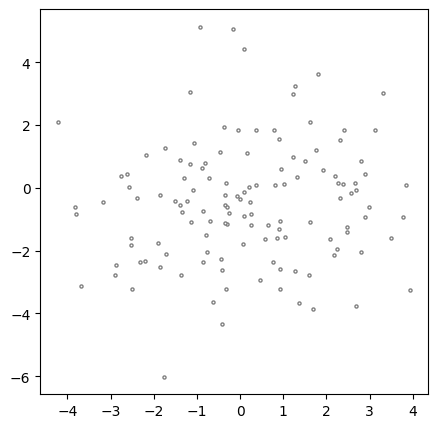

In [17]:
# visualize the sampled data points
def visualize_sampled_data(model):
  # print("Loss of the denoising model:", loss.item())
  x_T = torch.randn(128, 2)
  x_sampled = generate_samples_by_denoising(model, x_T, noise_schedule, n_T=1000, device=device).cpu().detach().numpy()

  # plt.scatter(x_sampled[:, 0], x_sampled[:, 1])
  fig, axs = plt.subplots(1, 1, figsize=(5, 5))
  axs.scatter(x_sampled[:,0], x_sampled[:,1], color='white', edgecolor='gray', s=5)
  # axs.set_axis_off()
  # plt.xlim(-3.6, 3.6)
  # plt.ylim(-3.6, 3.6)


visualize_sampled_data(model3)

Still looks like noise. What if we increase the length of training?

Training on device: cpu


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.3116355836391449


  0%|          | 0/1000 [00:00<?, ?it/s]

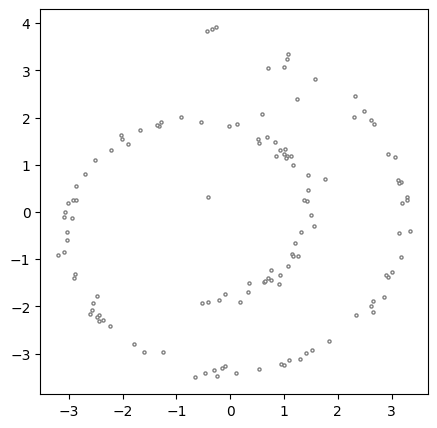

In [18]:
# Train some more
model3_loss = train(model3, model3_optimizer, steps=1000)
print("loss:", model3_loss.item())
visualize_sampled_data(model3)

That's more like it! In just 1000 training steps, we were able to go from complete noise to a fairly representative spiral.

#### Visualize Learned Denoising Trajectories

What do the denoising trajectories look like now, after 1000 training steps?

  0%|          | 0/1000 [00:00<?, ?it/s]

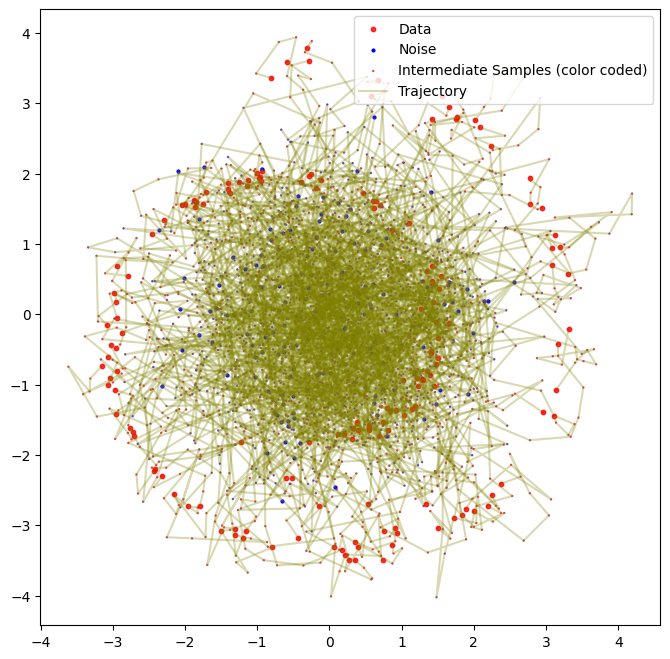

<Figure size 640x480 with 0 Axes>

In [19]:
# visualize denoising trajectories
visualize_denoising_trajectories(model3, n=160)

Wow, the blue dots (random starting points) took many turns and swirls to get back to the red dots (clean data)! It is surprising that they are able to even find the way back, let alone with such accuracy. Talk about the power of Math.

### Animate the learning process

To get a better idea of what the inbetween steps looked like, let's checkpoint the model and do a sampling every 100 training steps.

Click the play button to see the animation of generated samples as the model learns.

In [20]:
model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[128, 128, 256],
    num_timesteps=config.num_denoising_steps,
).to(device)
model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

samples = []
steps_to_checkpoint = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
all_trajs = []

for i in range(len(steps_to_checkpoint)):
    if i > 0:
        steps_to_train = steps_to_checkpoint[i] - steps_to_checkpoint[i-1]
    else:
        steps_to_train = i
    model3_loss = train(model3, model3_optimizer, steps=steps_to_train, silent=True)
    torch.manual_seed(0)
    traj = generate_samples_by_denoising(
        model3, torch.randn(128, 2), noise_schedule, n_T=1000, device=device, return_full_trajectory=True, silent=True)
    traj = traj.detach().cpu().numpy()
    reversed_traj = traj[::-20, :, :]
    traj_set = TrajectorySet(reversed_traj)
    all_trajs.append(traj_set)
    samples.append(traj[-1])


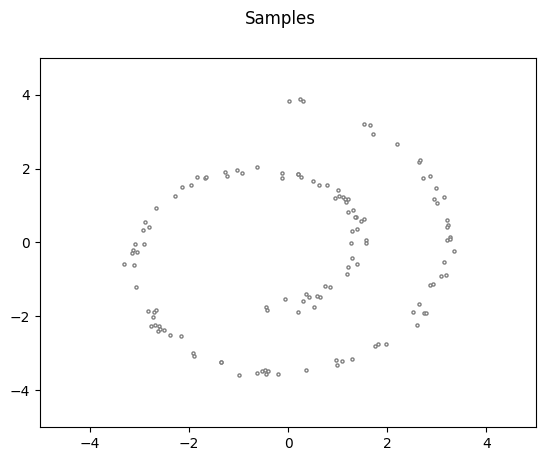

In [21]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
sc = ax.scatter(samples[i][:, 0], samples[i][:, 1], color='white', edgecolor='gray', s=5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
fig.suptitle("Samples")

def update(i):
    sc.set_offsets(samples[i])
    return sc,


ani = animation.FuncAnimation(fig, update, frames=range(len(steps_to_checkpoint)), interval=1000, blit=True, repeat=False)
HTML(ani.to_jshtml())

Drag the slider to see the denoising trajectories as the model learns.

In [22]:
# A shared state to store the frames for the vector field animation.
_state = {
    "frames": {},
}

from ipywidgets import interact

def show_traj_at_learning_step(i=0):
    train_steps = steps_to_checkpoint[i]
    bytes_value = all_trajs[i].plot_trajectories(
        n=32, show_figure=True, figsize=(6, 6),
        with_ticks=True, title=f"train steps = {train_steps}",
        xlim=(-5, 5), ylim=(-5, 7),
        with_lines=True,
    )
    _state["frames"][train_steps] = bytes_value

_ = interact(show_traj_at_learning_step, i=(0, len(all_trajs)-1, 1))

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

# Comparing Model Performance

While we can visually check if the generated point cloud is similar to the target spiral, it's helpful to have a quantitative metric. The Chamfer distance is an evaluation metric for similarity between two point clouds, so it's perfect for our data.

In [23]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def chamfer_distance(x, y, metric='l2', direction='bi'):
    """Chamfer distance between two point clouds

    Parameters
    ----------
    x: numpy array [n_points_x, n_dims]
        first point cloud
    y: numpy array [n_points_y, n_dims]
        second point cloud
    metric: string or callable, default 'l2'
        metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
    direction: str
        direction of Chamfer distance.
            'y_to_x':  computes average minimal distance from every point in y to x
            'x_to_y':  computes average minimal distance from every point in x to y
            'bi': compute both
    Returns
    -------
    chamfer_dist: float
        computed bidirectional Chamfer distance:
            sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||**2}} + sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||**2}}
    """
    
    if direction=='y_to_x':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        chamfer_dist = np.mean(min_y_to_x)
    elif direction=='x_to_y':
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_x_to_y)
    elif direction=='bi':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_y_to_x) + np.mean(min_x_to_y)
    else:
        raise ValueError("Invalid direction type. Supported types: \'y_x\', \'x_y\', \'bi\'")
        
    return chamfer_dist

## Model 1

model params: 199682
Training on device: cpu


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Reached the max training steps: 5000
model1_loss: 0.34836021065711975


  0%|          | 0/1000 [00:00<?, ?it/s]

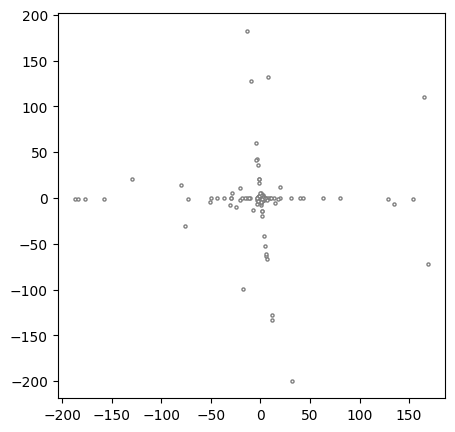

In [24]:
model1 = Model1(hidden_features=[512, 256, 256]).to(device)
print(f"model params: {sum(p.numel() for p in model1.parameters())}")

model1_optimizer = optim.AdamW(model1.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model1_loss = train(model1, model1_optimizer, steps=5000)
print("model1_loss:", model1_loss.item())
visualize_sampled_data(model1)

The shape looks terrible. But it is actually not that bad. Some points stray too far due to error accumulation. Let's clip the points to a reasonable range.

  0%|          | 0/1000 [00:00<?, ?it/s]

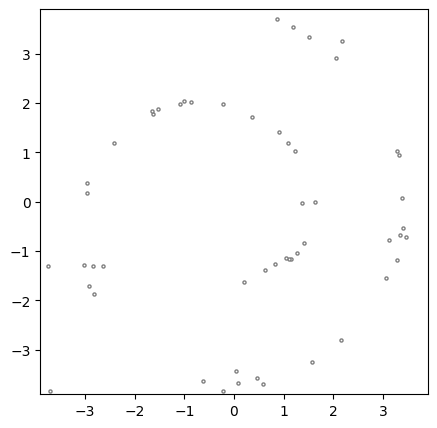

In [25]:
visualize_sampled_data(model1)
plt.xlim(-3.9, 3.9)
plt.ylim(-3.9, 3.9)
plt.show()

## Model 2

model params: 215554
Training on device: cpu


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Reached the max training steps: 5000
model2_loss: 0.3272062838077545


  0%|          | 0/1000 [00:00<?, ?it/s]

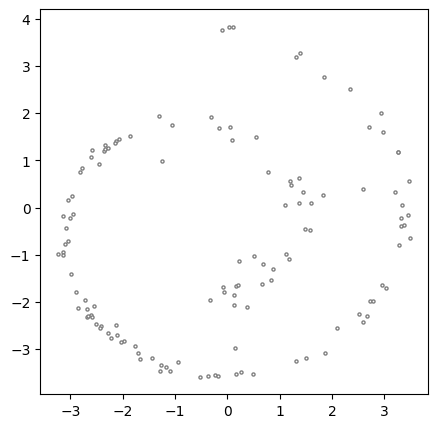

In [26]:
model2 = Model2(features=2, hidden_features=[512, 256, 256]).to(device)
print(f"model params: {sum(p.numel() for p in model2.parameters())}")

model2_optimizer = optim.AdamW(model2.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model2_loss = train(model2, model2_optimizer, steps=5000)
print("model2_loss:", model2_loss.item())
visualize_sampled_data(model2)

## Model 3

model params: 182410
Training on device: cpu


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Reached the max training steps: 5000
model3_loss: 0.2785179913043976


  0%|          | 0/1000 [00:00<?, ?it/s]

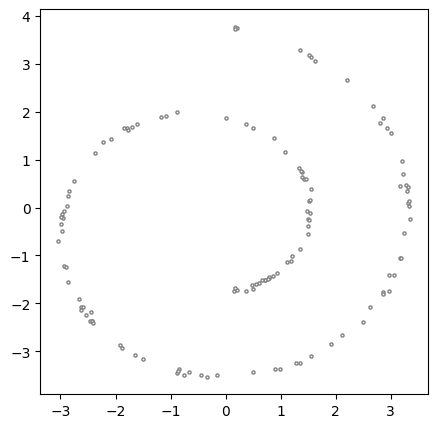

In [27]:
model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[128, 128, 128],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")

model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model3_loss = train(model3, model3_optimizer, steps=5000)
print("model3_loss:", model3_loss.item())
visualize_sampled_data(model3)

  0%|          | 0/1000 [00:00<?, ?it/s]

Model 1 Size: 199682 Chamfer Distance: 1.1920804347906755


  0%|          | 0/1000 [00:00<?, ?it/s]

Model 2 Size: 215554 Chamfer Distance: 0.3012108333136537


  0%|          | 0/1000 [00:00<?, ?it/s]

Model 3 Size: 182410 Chamfer Distance: 0.18239878315537367


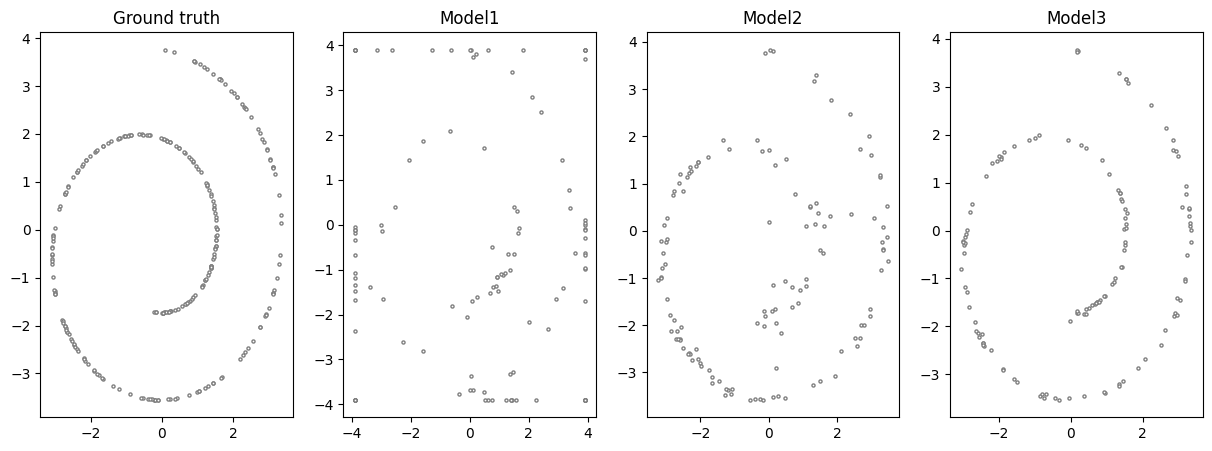

In [28]:
import torch

# Sample points from the model
def generate_points(model):
    with torch.no_grad():
        x_T = torch.randn(128, 2)
        x_sampled = generate_samples_by_denoising(model, x_T, noise_schedule, n_T=1000, device=device)
    return x_sampled.cpu().numpy()


# The target spiral points for comparison
target_spiral = next(iter(train_dataloader))

generated_points_1 = generate_points(model1)
generated_points_1 = np.clip(generated_points_1, -3.9, 3.9)
chamfer_dist = chamfer_distance(generated_points_1, target_spiral, direction='bi')
print("Model 1 Size:", sum(p.numel() for p in model1.parameters()), "Chamfer Distance:", chamfer_dist)


generated_points_2 = generate_points(model2)
chamfer_dist = chamfer_distance(generated_points_2, target_spiral, direction='bi')
print("Model 2 Size:", sum(p.numel() for p in model2.parameters()), "Chamfer Distance:", chamfer_dist)

# Calculate Chamfer distance
generated_points_3 = generate_points(model3)
chamfer_dist = chamfer_distance(generated_points_3, target_spiral, direction='bi')
print("Model 3 Size:", sum(p.numel() for p in model3.parameters()), "Chamfer Distance:", chamfer_dist)

# # visualize the sampled data points side by side
def visualize_sampled_data_side_by_side(models, generated_points):
    fig, axs = plt.subplots(1, len(models) + 1, figsize=(5 * len(models), 5))
    # Add ground truth
    axs[0].scatter(target_spiral[:, 0], target_spiral[:, 1], color='white', edgecolor='gray', s=5)
    axs[0].set_title("Ground truth")

    for i, (model, points) in enumerate(zip(models, generated_points)):
        axs[i+1].scatter(points[:,0], points[:,1], color='white', edgecolor='gray', s=5)
        axs[i+1].set_title(model.__class__.__name__)

visualize_sampled_data_side_by_side([model1, model2, model3], [generated_points_1, generated_points_2, generated_points_3])

Let's compare how our three architectural approaches performed:

1. Model 1 (Basic): Shows decent spiral structure but with significant noise
2. Model 2 (Sinusoidal): Improved spiral with less noise
3. Model 3 (Modulation): Cleanest results with least noise

The Chamfer distance also tells us the same story, with model 3 having the lowest distance to the target spiral.


## Key Takeaways and Discussion

We've seen how diffusion models can learn to generate complex patterns, even with a simple architecture. Some key observations:

- Forward diffusion provides a structured way to add noise.
- The choice of architecture significantly impacts generation quality. Time embedding strategy matters for model performance.

### Discussion Questions
- What do you think is the role of forward diffusion for training?
- What is the role of time embeddings?
- Do you think the model architecture matters for the quality of the generated samples?
- How many training examples are sufficient for the model to learn the data distribution?